/tmp/ipython-input-3831203346.py:16: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date'] = pd.to_datetime(df['date']).dt.date


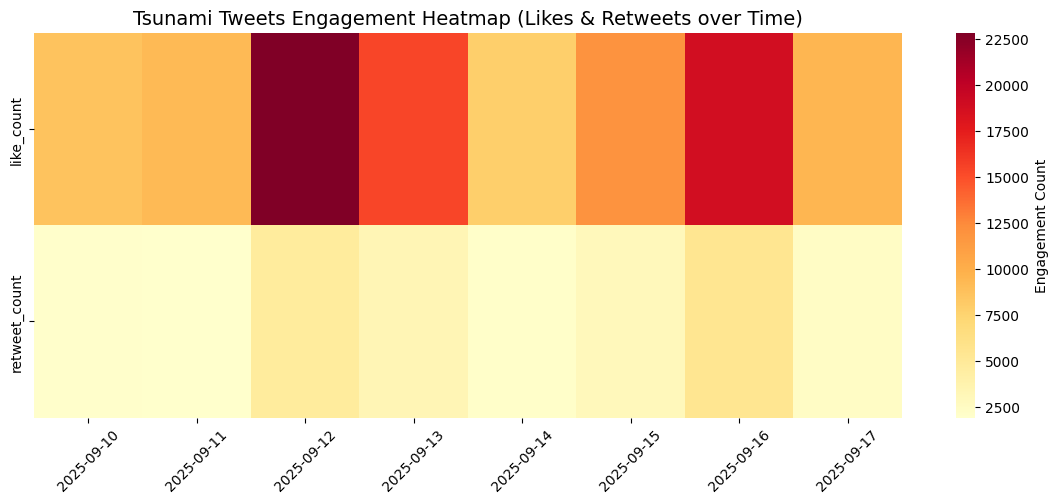

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV
df = pd.read_csv("tsunami_tweets.csv")

# Rename columns to standard names
df.rename(columns={
    'Created At': 'date',
    'Likes': 'like_count',
    'Retweets': 'retweet_count'
}, inplace=True)

# Convert date column
df['date'] = pd.to_datetime(df['date']).dt.date

# Group by date to sum engagements
engagement = df.groupby('date')[['like_count', 'retweet_count']].sum().reset_index()

# Prepare data for heatmap
heatmap_data = engagement.set_index('date').T

# Plot heatmap
plt.figure(figsize=(14, 5))
sns.heatmap(
    heatmap_data,
    cmap="YlOrRd",
    annot=False,  # change to True if you want numbers in cells
    cbar_kws={'label': 'Engagement Count'}
)

plt.title("Tsunami Tweets Engagement Heatmap (Likes & Retweets over Time)", fontsize=14)
plt.ylabel("")
plt.xlabel("")
plt.xticks(rotation=45)
plt.show()


In [3]:
print(df.columns.tolist())

['Tweet_count', 'Username', 'Text', 'Created At', 'Retweets', 'Likes']


In [5]:
!pip install transformers torch pandas matplotlib

import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import numpy as np
from tqdm.notebook import tqdm

# Load dataset
df = pd.read_csv("tsunami_tweets.csv")

# Rename for consistency
df.rename(columns={'Created At': 'date', 'Text': 'text'}, inplace=True)
df['date'] = pd.to_datetime(df['date']).dt.date

# Load sentiment model
roberta = "cardiffnlp/twitter-roberta-base-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta)
labels = ['Negative', 'Neutral', 'Positive']

def preprocess_tweet(tweet):
    words = []
    for word in str(tweet).split(" "):
        if word.startswith('@') and len(word) > 1:
            word = '@user'
        elif word.startswith('http'):
            word = "http"
        words.append(word)
    return " ".join(words)

def get_sentiment(tweet):
    tweet_proc = preprocess_tweet(tweet)
    encoded_tweet = tokenizer(tweet_proc, return_tensors='pt')
    output = model(**encoded_tweet)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return labels[np.argmax(scores)]  # return label with highest score

# Run sentiment analysis
tqdm.pandas()
df['sentiment'] = df['text'].progress_apply(get_sentiment)

# Count tweets per sentiment per date
sentiment_trend = df.groupby(['date', 'sentiment']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(12,6))
plt.plot(sentiment_trend.index, sentiment_trend['Positive'], label="Positive", color="green", marker='o')
plt.plot(sentiment_trend.index, sentiment_trend['Neutral'], label="Neutral", color="blue", marker='o')
plt.plot(sentiment_trend.index, sentiment_trend['Negative'], label="Negative", color="red", marker='o')

plt.title("Sentiment Trend for 'Tsunami' Tweets")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipython-input-3289027135.py:15: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date'] = pd.to_datetime(df['date']).dt.date
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

KeyboardInterrupt: 